In [1]:
from environments.utils import create_data
import matplotlib.pyplot as plt
import os
from typing import Tuple, List
import torch
from environments.environment import SP500TradingEnv

In [2]:
class TimeSeriesAutoEncoder(torch.nn.Module):
    def __init__(self, matrix_shape: Tuple[int, int], hidden_sizes: List[int]):
        super(TimeSeriesAutoEncoder, self).__init__()
        self.matrix_shape = matrix_shape
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(matrix_shape[0] * matrix_shape[1], hidden_sizes[0]),
        )
        # iterate through the hidden sizes and create a linear layer for each
        for i in range(1, len(hidden_sizes)):
            self.encoder.add_module(f'linear_{i}', torch.nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
        self.decoder = torch.nn.Sequential()
        # iterate through the hidden sizes backwards and create a linear layer for each
        for i in range(len(hidden_sizes)-1, 0, -1):
            self.decoder.add_module(f'linear_{i + len(hidden_sizes)}', torch.nn.Linear(hidden_sizes[i], hidden_sizes[i-1]))
        # add the final linear layer to decode the data back to the original shape
        self.decoder.add_module(f'linear_{2 * len(hidden_sizes)}', torch.nn.Linear(hidden_sizes[0], matrix_shape[0] * matrix_shape[1]))
    def forward(self, x):
        # flatten the input
        x = x.view(x.size(0), -1)
        x = self.encoder(x)
        x = self.decoder(x)
        # reshape the output
        x = x.view(x.size(0), *self.matrix_shape)
        return x

In [3]:
def train_autoencoder(model, train_loader, test_loader, optimizer, criterion, epochs, device='cuda'):
    train_losses = []
    test_losses = []
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0
        for batch_idx, data in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        train_loss /= len(train_loader.dataset)
        print(f'====> Epoch: {epoch} Average loss: {train_loss}')
        train_losses.append(train_loss)
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for data in test_loader:
                data = data.to(device)
                output = model(data)
                test_loss += criterion(output, data).item()
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        print(f'Test set loss after epoch {epoch}: {test_loss}')
    return train_losses, test_losses

In [4]:
# create window dataloader from sp500_df_tech_indicators_time_enc using pytorch
import torch
from torch.utils.data import Dataset, DataLoader
# define class for window dataset
class WindowDataset(Dataset):
    def __init__(self, data, window_size):
        self.data = torch.tensor(data.values, dtype=torch.float32)
        self.window_size = window_size
    def __len__(self):
        return len(self.data) - self.window_size
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        window = self.data[idx:idx+self.window_size]
        return window

# Weighted average scaling
The below experiments were performed on the data with weighted average scaling from 2000-01-01

In [5]:
import json
import pandas as pd
# load train data
with open('C:/Users/Maciej/PycharmProjects/FinDL/data/train_180_window_weighted.json', 'r') as f:
    sp500_weighted_train = json.load(f)

# load test data
with open('C:/Users/Maciej/PycharmProjects/FinDL/data/test_180_window_weighted.json', 'r') as f:
    sp500_weighted_test = json.load(f)

# create dataframes from jsons
sp500_weighted_train = pd.DataFrame(sp500_weighted_train)
sp500_weighted_test = pd.DataFrame(sp500_weighted_test)

sp500_weighted_train.head()

open      high       low     close    volume       ADL  \
946857600000 -0.319710 -0.372941 -1.024095 -0.791516 -0.067454 -1.886077   
946944000000 -0.791514 -1.219826 -2.372432 -2.754114  0.490248 -2.419832   
947030400000 -2.754110 -2.791663 -2.991193 -2.658737  1.024108 -2.084165   
947116800000 -2.658733 -2.810714 -2.504685 -2.605828  1.042872 -1.946706   
947203200000 -2.605824 -1.657795 -2.167861 -1.242119  1.935692 -1.137118   

                   ADX        AO       ATR   BBWIDTH  ...  WILLIAMS       WMA  \
946857600000  8.709736 -2.122103  1.873549  1.255436  ...  0.221401 -1.640503   
946944000000  8.869052 -2.074939  1.911441  1.279211  ...  0.245439 -1.661720   
947030400000  9.021569 -1.999233  1.941351  1.295658  ...  0.271206 -1.675192   
947116800000  9.159507 -1.891166  1.974421  1.305171  ...  0.296885 -1.680632   
947203200000  9.266647 -1.765780  2.002280  1.308586  ...  0.319618 -1.677223   

                  WOBV     ZLEMA  sin_weekday  cos_weekday  sin_monthday  \
946857600000 -3.677820 -1.538478    -0.663411     1.432057      0.751655   
946944000000 -3.679574 -1.563500     0.831187     0.926933      0.991995   
947030400000 -3.546462 -1.581388     1.172481    -0.164764      1.190515   
947116800000 -3.457537 -1.591464     0.126303    -1.026711      1.336954   
947203200000 -1.750453 -1.593827    -1.506609    -1.002914      1.426593   

              cos_monthday  sin_yearday  cos_yearday  
946857600000      1.236184     1.211480     5.010039  
946944000000      1.075089     1.286443     4.926381  
947030400000      0.872406     1.361667     4.843173  
947116800000      0.634167     1.437242     4.760354  
947203200000      0.366374     1.512845     4.678113  

[5 rows x 71 columns]

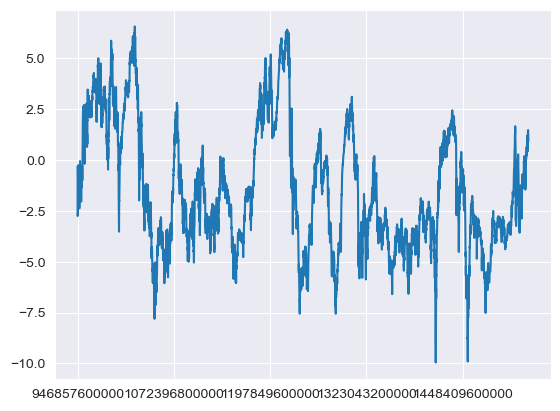

In [6]:
# plot open price
sp500_weighted_train['open'].plot()
plt.show()

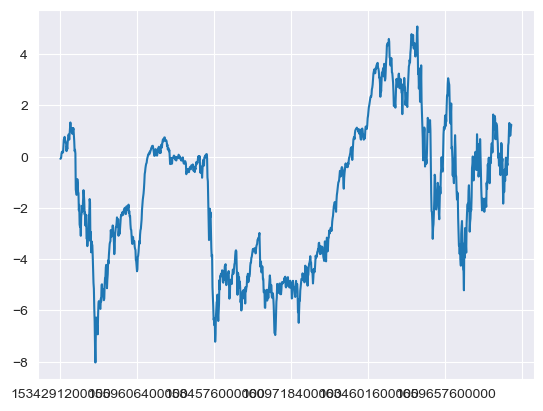

In [9]:
# plot open price
sp500_weighted_test['open'].plot()
plt.show()

In [11]:
# check if there are None values in train data
sp500_weighted_train.isna().sum()

open            0
high            0
low             0
close           0
volume          0
               ..
cos_weekday     0
sin_monthday    0
cos_monthday    0
sin_yearday     0
cos_yearday     0
Length: 71, dtype: int64

SQZMI contains None values so we will drop it

In [7]:
sp500_weighted_train.drop(columns=['SQZMI'], inplace=True)
sp500_weighted_test.drop(columns=['SQZMI'], inplace=True)

### Latent space of 256 and 4 layers

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 128
window_size = 60
matrix_shape = (window_size, sp500_weighted_train.shape[1])
train_dataset_60 = WindowDataset(sp500_weighted_train, window_size)
test_dataset_60 = WindowDataset(sp500_weighted_test, window_size)
train_loader_60 = DataLoader(train_dataset_60, batch_size=batch_size, shuffle=False)
test_loader_60 = DataLoader(test_dataset_60, batch_size=batch_size, shuffle=False)
hidden_sizes = [2048, 1024, 512, 256]
model_256_4_layers = TimeSeriesAutoEncoder(matrix_shape, hidden_sizes).to(device)
optimizer = torch.optim.Adam(model_256_4_layers.parameters(), lr=5e-5)
criterion = torch.nn.MSELoss()
epochs = 1600
train_losses_60_3_layers, test_losses_60_3_layers = train_autoencoder(model_256_4_layers, train_loader_60, test_loader_60, optimizer, criterion, epochs)

====> Epoch: 1 Average loss: 0.03190582973889001
Test set loss after epoch 1: 0.02162591962934398
====> Epoch: 2 Average loss: 0.019534463043547008
Test set loss after epoch 2: 0.018975473457960773
====> Epoch: 3 Average loss: 0.017400441388357883
Test set loss after epoch 3: 0.01683121319297406
====> Epoch: 4 Average loss: 0.015700203131330054
Test set loss after epoch 4: 0.015222345217526388
====> Epoch: 5 Average loss: 0.014339457759085824
Test set loss after epoch 5: 0.013943243744990808
====> Epoch: 6 Average loss: 0.012902403875515122
Test set loss after epoch 6: 0.012542518726784548
====> Epoch: 7 Average loss: 0.01145512984491962
Test set loss after epoch 7: 0.012042212561308909
====> Epoch: 8 Average loss: 0.01121593813273321
Test set loss after epoch 8: 0.01066914050699138
====> Epoch: 9 Average loss: 0.010248012363807553
Test set loss after epoch 9: 0.009676778702427157
====> Epoch: 10 Average loss: 0.009487162218477486
Test set loss after epoch 10: 0.00919989909199502
====>

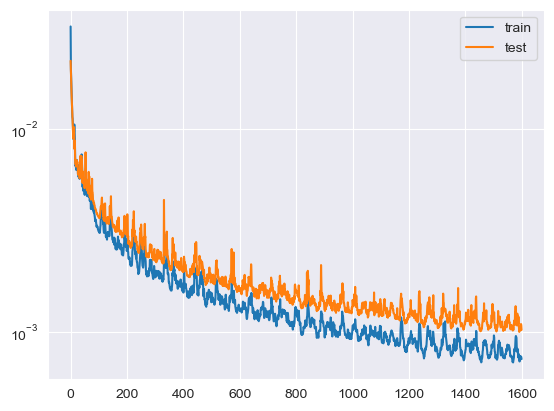

In [14]:
# plot losses in the training and test set on the log scale
plt.plot(train_losses_60_3_layers, label='train')
plt.plot(test_losses_60_3_layers, label='test')
plt.yscale('log')
plt.legend()
plt.show()

In [8]:
# # extract the encoder part of the autoencoder
# encoder_256_4_layers = model_256_4_layers.encoder
# # # save the encoder
# torch.save(encoder_256_4_layers,  'encoder_256_4_layers.pt')
# load the encoder
device = "cuda" if torch.cuda.is_available() else "cpu"
encoder_256_4_layers = torch.load('encoder_256_4_layers.pt')
# move the encoder to the gpu
encoder_256_4_layers = encoder_256_4_layers.to(device)

In [9]:
from torch import nn
import gym
import numpy as np
class SP500TradingEnvAutoencoder(SP500TradingEnv):
    def __init__(self, sp500_df_observations, sp500_df_real_prices, window_len=10, encoder:     nn.Module= None, device: str = 'cuda'):
        super().__init__(sp500_df_observations, sp500_df_real_prices, window_len)
        self.encoder = encoder
        self.device = device
        self.representations = self.calculate_representations()
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(int(self.representations[0].shape[0]),), dtype=np.float32)

    def calculate_representations(self) -> List[torch.tensor]:
        values_on_gpu = torch.tensor(self.sp500_df_features.values, dtype=torch.float32).to(self.device)
        return [torch.flatten(self.encoder(values_on_gpu[tick: tick + self.window_len].reshape(1, self.window_len * self.features))) for tick in range(0, self.end_tick + 1)]

    def get_observation(self):
        return self.representations[self.episode_tick].to('cpu').detach().numpy()

In [12]:
# get not scaled data
sp500_df_train_not_scaled, sp500_df_test_not_scaled = create_data(start_="2000-01-01",end_='2023-04-13', scale_to_std=False, scale_min_max=False)

C:\Users\Maciej\anaconda3\envs\pytorch_gpu\lib\site-packages\finta\finta.py:399: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for x, y in zip(x.fillna(0).iteritems(), y.iteritems()):
C:\Users\Maciej\anaconda3\envs\pytorch_gpu\lib\site-packages\finta\finta.py:399: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for x, y in zip(x.fillna(0).iteritems(), y.iteritems()):
C:\Users\Maciej\anaconda3\envs\pytorch_gpu\lib\site-packages\finta\finta.py:399: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for x, y in zip(x.fillna(0).iteritems(), y.iteritems()):
C:\Users\Maciej\anaconda3\envs\pytorch_gpu\lib\site-packages\finta\finta.py:399: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for x, y in zip(x.fillna(0).iteritems(), y.iteritems()):
C:\Users\Maciej\anaconda3\envs\pytorch_g

In [11]:
# save not scaled to CSV
sp500_df_train_not_scaled.to_csv('sp500_df_train_not_scaled.csv')
sp500_df_test_not_scaled.to_csv('sp500_df_test_not_scaled.csv')

In [13]:
env_weighted_256 = SP500TradingEnvAutoencoder(sp500_weighted_train, sp500_df_train_not_scaled, window_len=60, encoder=encoder_256_4_layers, device=device)

C:\Users\Maciej\anaconda3\envs\pytorch_gpu\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Create and train agent

In [14]:
# create and train agent
from stable_baselines3 import PPO
model_256_ppo = PPO('MlpPolicy', env_weighted_256, verbose=1)
model_256_ppo.learn(total_timesteps=100_000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 534  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 437        |
|    iterations           | 2          |
|    time_elapsed         | 9          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.02430015 |
|    clip_fraction        | 0.125      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.41      |
|    explained_variance   | -2.11      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0518    |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.0349    |
|    std                  | 0.973      

In [15]:
# simulate agent on environment
obs = env_weighted_256.reset()
for i in range(env_weighted_256.end_tick):
    action, _states = model_256_ppo.predict(obs, deterministic=True)
    obs, rewards, dones, info = env_weighted_256.step(action)
    env_weighted_256.render()
    if dones:
        print("info:", info)
        break

Episode tick: 1
Portfolio value: [1.000524]
SP500: [1.000524]
Cash: [0.]
Done: False
Episode tick: 2
Portfolio value: [0.9868611]
SP500: [0.9868611]
Cash: [0.]
Done: False
Episode tick: 3
Portfolio value: [0.9884395]
SP500: [0.22189122]
Cash: [0.7665483]
Done: False
Episode tick: 4
Portfolio value: [0.9884395]
SP500: [0.]
Cash: [0.9884395]
Done: False
Episode tick: 5
Portfolio value: [0.9884395]
SP500: [0.]
Cash: [0.9884395]
Done: False
Episode tick: 6
Portfolio value: [0.9884395]
SP500: [0.]
Cash: [0.9884395]
Done: False
Episode tick: 7
Portfolio value: [0.9977233]
SP500: [0.9977233]
Cash: [0.]
Done: False
Episode tick: 8
Portfolio value: [1.0051765]
SP500: [0.7529531]
Cash: [0.2522235]
Done: False
Episode tick: 9
Portfolio value: [0.9972947]
SP500: [0.9972947]
Cash: [0.]
Done: False
Episode tick: 10
Portfolio value: [0.9972947]
SP500: [0.]
Cash: [0.9972947]
Done: False
Episode tick: 11
Portfolio value: [0.99300396]
SP500: [0.1883678]
Cash: [0.8046362]
Done: False
Episode tick: 12
Por

In [16]:
# evaluate agent on test environment
env_weighted_256_test = SP500TradingEnvAutoencoder(sp500_weighted_test, sp500_df_test_not_scaled, window_len=60, encoder=encoder_256_4_layers, device=device)

C:\Users\Maciej\anaconda3\envs\pytorch_gpu\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [17]:
obs = env_weighted_256_test.reset()
for i in range(env_weighted_256_test.end_tick):
    action, _states = model_256_ppo.predict(obs, deterministic=True)
    obs, rewards, dones, info = env_weighted_256_test.step(action)
    env_weighted_256_test.render()
    if dones:
        print("info:", info)
        break

Episode tick: 1
Portfolio value: [1.0001304]
SP500: [0.81253266]
Cash: [0.18759769]
Done: False
Episode tick: 2
Portfolio value: [1.0001304]
SP500: [0.]
Cash: [1.0001304]
Done: False
Episode tick: 3
Portfolio value: [1.0001304]
SP500: [0.]
Cash: [1.0001304]
Done: False
Episode tick: 4
Portfolio value: [0.999998]
SP500: [0.04581184]
Cash: [0.95418614]
Done: False
Episode tick: 5
Portfolio value: [0.99949735]
SP500: [0.03723764]
Cash: [0.9622597]
Done: False
Episode tick: 6
Portfolio value: [1.0131084]
SP500: [1.0131084]
Cash: [0.]
Done: False
Episode tick: 7
Portfolio value: [1.0197157]
SP500: [1.0197157]
Cash: [0.]
Done: False
Episode tick: 8
Portfolio value: [1.0124017]
SP500: [0.49187174]
Cash: [0.52053]
Done: False
Episode tick: 9
Portfolio value: [1.0075543]
SP500: [1.0075543]
Cash: [0.]
Done: False
Episode tick: 10
Portfolio value: [1.0045935]
SP500: [1.0045935]
Cash: [0.]
Done: False
Episode tick: 11
Portfolio value: [1.0043288]
SP500: [0.8707943]
Cash: [0.13353455]
Done: False
E

### Train model for less iterations

In [18]:
model_50k_ppo = PPO('MlpPolicy', env_weighted_256, verbose=1)
model_50k_ppo.learn(total_timesteps=50_000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 513  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 427         |
|    iterations           | 2           |
|    time_elapsed         | 9           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.024363792 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.4        |
|    explained_variance   | -4.4        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0589     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0332     |
|    std               

In [19]:
# test model on train environment
obs = env_weighted_256.reset()
for i in range(env_weighted_256.end_tick):
    action, _states = model_50k_ppo.predict(obs, deterministic=True)
    obs, rewards, dones, info = env_weighted_256.step(action)
    env_weighted_256.render()
    if dones:
        print("info:", info)
        break

Episode tick: 1
Portfolio value: [1.]
SP500: [0.]
Cash: [1.]
Done: False
Episode tick: 2
Portfolio value: [0.9999136]
SP500: [0.00624351]
Cash: [0.99367005]
Done: False
Episode tick: 3
Portfolio value: [1.0068147]
SP500: [0.9701507]
Cash: [0.03666395]
Done: False
Episode tick: 4
Portfolio value: [1.0068147]
SP500: [0.]
Cash: [1.0068147]
Done: False
Episode tick: 5
Portfolio value: [1.001823]
SP500: [0.66324043]
Cash: [0.33858246]
Done: False
Episode tick: 6
Portfolio value: [1.001206]
SP500: [0.12466263]
Cash: [0.87654346]
Done: False
Episode tick: 7
Portfolio value: [1.00767]
SP500: [0.69467974]
Cash: [0.3129903]
Done: False
Episode tick: 8
Portfolio value: [1.009647]
SP500: [0.19971511]
Cash: [0.8099319]
Done: False
Episode tick: 9
Portfolio value: [1.009647]
SP500: [0.]
Cash: [1.009647]
Done: False
Episode tick: 10
Portfolio value: [1.009647]
SP500: [0.]
Cash: [1.009647]
Done: False
Episode tick: 11
Portfolio value: [0.9871609]
SP500: [0.9871609]
Cash: [0.]
Done: False
Episode tick:

In [20]:
# test model on test environment
obs = env_weighted_256_test.reset()
for i in range(env_weighted_256_test.end_tick):
    action, _states = model_50k_ppo.predict(obs, deterministic=True)
    obs, rewards, dones, info = env_weighted_256_test.step(action)
    env_weighted_256_test.render()
    if dones:
        print("info:", info)
        break

Episode tick: 1
Portfolio value: [1.0000005]
SP500: [0.00284873]
Cash: [0.99715173]
Done: False
Episode tick: 2
Portfolio value: [1.0000005]
SP500: [0.]
Cash: [1.0000005]
Done: False
Episode tick: 3
Portfolio value: [1.0000005]
SP500: [0.]
Cash: [1.0000005]
Done: False
Episode tick: 4
Portfolio value: [1.0000005]
SP500: [0.]
Cash: [1.0000005]
Done: False
Episode tick: 5
Portfolio value: [1.0000005]
SP500: [0.]
Cash: [1.0000005]
Done: False
Episode tick: 6
Portfolio value: [1.0000005]
SP500: [0.]
Cash: [1.0000005]
Done: False
Episode tick: 7
Portfolio value: [1.0000005]
SP500: [0.]
Cash: [1.0000005]
Done: False
Episode tick: 8
Portfolio value: [1.0000005]
SP500: [0.]
Cash: [1.0000005]
Done: False
Episode tick: 9
Portfolio value: [1.0000005]
SP500: [0.]
Cash: [1.0000005]
Done: False
Episode tick: 10
Portfolio value: [1.0000005]
SP500: [0.]
Cash: [1.0000005]
Done: False
Episode tick: 11
Portfolio value: [1.0000005]
SP500: [0.]
Cash: [1.0000005]
Done: False
Episode tick: 12
Portfolio value

### Train model for more iterations

In [21]:
model_200k_ppo = PPO('MlpPolicy', env_weighted_256, verbose=1)
model_200k_ppo.learn(total_timesteps=200_000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 502  |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 2048 |
-----------------------------
--------------------------------------
| time/                   |          |
|    fps                  | 422      |
|    iterations           | 2        |
|    time_elapsed         | 9        |
|    total_timesteps      | 4096     |
| train/                  |          |
|    approx_kl            | 0.023284 |
|    clip_fraction        | 0.116    |
|    clip_range           | 0.2      |
|    entropy_loss         | -1.41    |
|    explained_variance   | -3.12    |
|    learning_rate        | 0.0003   |
|    loss                 | -0.0632  |
|    n_updates            | 10       |
|    policy_gradient_loss | -0.0344  |
|    std                  | 0.98     |
|    value_loss           | 0.05

In [22]:
# test model on train environment
obs = env_weighted_256.reset()
for i in range(env_weighted_256.end_tick):
    action, _states = model_200k_ppo.predict(obs, deterministic=True)
    obs, rewards, dones, info = env_weighted_256.step(action)
    env_weighted_256.render()
    if dones:
        print("info:", info)
        break

Episode tick: 1
Portfolio value: [1.0003448]
SP500: [0.65825087]
Cash: [0.34209388]
Done: False
Episode tick: 2
Portfolio value: [0.9968308]
SP500: [0.25380862]
Cash: [0.7430222]
Done: False
Episode tick: 3
Portfolio value: [0.9968308]
SP500: [0.]
Cash: [0.9968308]
Done: False
Episode tick: 4
Portfolio value: [0.9968308]
SP500: [0.]
Cash: [0.9968308]
Done: False
Episode tick: 5
Portfolio value: [0.9968308]
SP500: [0.]
Cash: [0.9968308]
Done: False
Episode tick: 6
Portfolio value: [0.9968308]
SP500: [0.]
Cash: [0.9968308]
Done: False
Episode tick: 7
Portfolio value: [1.0061934]
SP500: [1.0061934]
Cash: [0.]
Done: False
Episode tick: 8
Portfolio value: [1.011142]
SP500: [0.4999251]
Cash: [0.51121694]
Done: False
Episode tick: 9
Portfolio value: [1.0032134]
SP500: [1.0032134]
Cash: [0.]
Done: False
Episode tick: 10
Portfolio value: [1.0029196]
SP500: [0.11396243]
Cash: [0.8889571]
Done: False
Episode tick: 11
Portfolio value: [0.9805833]
SP500: [0.9805833]
Cash: [0.]
Done: False
Episode t

In [23]:
# test model on test environment
obs = env_weighted_256_test.reset()
for i in range(env_weighted_256_test.end_tick):
    action, _states = model_200k_ppo.predict(obs, deterministic=True)
    obs, rewards, dones, info = env_weighted_256_test.step(action)
    env_weighted_256_test.render()
    if dones:
        print("info:", info)
        break

Episode tick: 1
Portfolio value: [1.0000459]
SP500: [0.28632474]
Cash: [0.71372116]
Done: False
Episode tick: 2
Portfolio value: [1.0000459]
SP500: [0.]
Cash: [1.0000459]
Done: False
Episode tick: 3
Portfolio value: [0.990433]
SP500: [0.54929644]
Cash: [0.44113654]
Done: False
Episode tick: 4
Portfolio value: [0.9898715]
SP500: [0.19419743]
Cash: [0.7956741]
Done: False
Episode tick: 5
Portfolio value: [0.9898715]
SP500: [0.]
Cash: [0.9898715]
Done: False
Episode tick: 6
Portfolio value: [0.9898715]
SP500: [0.]
Cash: [0.9898715]
Done: False
Episode tick: 7
Portfolio value: [0.9913072]
SP500: [0.22157381]
Cash: [0.76973337]
Done: False
Episode tick: 8
Portfolio value: [0.9913072]
SP500: [0.]
Cash: [0.9913072]
Done: False
Episode tick: 9
Portfolio value: [0.9913072]
SP500: [0.]
Cash: [0.9913072]
Done: False
Episode tick: 10
Portfolio value: [0.9913072]
SP500: [0.]
Cash: [0.9913072]
Done: False
Episode tick: 11
Portfolio value: [0.9910996]
SP500: [0.68311757]
Cash: [0.30798203]
Done: Fals

#### Test model without deterministic flag
Train set

In [24]:
obs = env_weighted_256.reset()
for i in range(env_weighted_256.end_tick):
    action, _states = model_200k_ppo.predict(obs)
    obs, rewards, dones, info = env_weighted_256.step(action)
    env_weighted_256.render()
    if dones:
        print("info:", info)
        break

Episode tick: 1
Portfolio value: [1.0003175]
SP500: [0.6060479]
Cash: [0.39426953]
Done: False
Episode tick: 2
Portfolio value: [0.9969717]
SP500: [0.2416604]
Cash: [0.7553113]
Done: False
Episode tick: 3
Portfolio value: [0.9969717]
SP500: [0.]
Cash: [0.9969717]
Done: False
Episode tick: 4
Portfolio value: [0.9969717]
SP500: [0.]
Cash: [0.9969717]
Done: False
Episode tick: 5
Portfolio value: [0.9969717]
SP500: [0.]
Cash: [0.9969717]
Done: False
Episode tick: 6
Portfolio value: [0.9969717]
SP500: [0.]
Cash: [0.9969717]
Done: False
Episode tick: 7
Portfolio value: [1.0063356]
SP500: [1.0063356]
Cash: [0.]
Done: False
Episode tick: 8
Portfolio value: [1.0113653]
SP500: [0.50811404]
Cash: [0.50325125]
Done: False
Episode tick: 9
Portfolio value: [1.0034349]
SP500: [1.0034349]
Cash: [0.]
Done: False
Episode tick: 10
Portfolio value: [1.002948]
SP500: [0.18876396]
Cash: [0.8141841]
Done: False
Episode tick: 11
Portfolio value: [0.98061115]
SP500: [0.98061115]
Cash: [0.]
Done: False
Episode 

In [25]:
# test model on test environment
obs = env_weighted_256_test.reset()
for i in range(env_weighted_256_test.end_tick):
    action, _states = model_200k_ppo.predict(obs)
    obs, rewards, dones, info = env_weighted_256_test.step(action)
    env_weighted_256_test.render()
    if dones:
        print("info:", info)
        break

Episode tick: 1
Portfolio value: [1.0000474]
SP500: [0.29579046]
Cash: [0.704257]
Done: False
Episode tick: 2
Portfolio value: [1.0000474]
SP500: [0.]
Cash: [1.0000474]
Done: False
Episode tick: 3
Portfolio value: [0.9893262]
SP500: [0.61262846]
Cash: [0.37669772]
Done: False
Episode tick: 4
Portfolio value: [0.988652]
SP500: [0.23319289]
Cash: [0.7554591]
Done: False
Episode tick: 5
Portfolio value: [0.988652]
SP500: [0.]
Cash: [0.988652]
Done: False
Episode tick: 6
Portfolio value: [0.988652]
SP500: [0.]
Cash: [0.988652]
Done: False
Episode tick: 7
Portfolio value: [0.9903711]
SP500: [0.265318]
Cash: [0.72505313]
Done: False
Episode tick: 8
Portfolio value: [0.9903711]
SP500: [0.]
Cash: [0.9903711]
Done: False
Episode tick: 9
Portfolio value: [0.9903711]
SP500: [0.]
Cash: [0.9903711]
Done: False
Episode tick: 10
Portfolio value: [0.9903711]
SP500: [0.]
Cash: [0.9903711]
Done: False
Episode tick: 11
Portfolio value: [0.99014723]
SP500: [0.7366649]
Cash: [0.25348234]
Done: False
Episod

## Testing the approach on the data from 2005
Loading the data

In [30]:
with open('C:/Users/Maciej/PycharmProjects/FinDL/data/train_df_cut.json', 'r') as f:
    sp500_weighted_train_2005 = json.load(f)

# load test data
with open('C:/Users/Maciej/PycharmProjects/FinDL/data/test_df_cut.json', 'r') as f:
    sp500_weighted_test_2005 = json.load(f)

# create dataframes from jsons
sp500_weighted_train_2005 = pd.DataFrame(sp500_weighted_train_2005)
sp500_weighted_test_2005 = pd.DataFrame(sp500_weighted_test_2005)

sp500_weighted_train_2005.head()

open      high       low     close    volume       ADL  \
1104710400000 -0.571665 -0.546129 -1.003640 -1.208139 -1.429192 -2.358469   
1104796800000 -1.208586 -1.345094 -1.956931 -2.118927 -0.687456 -2.771082   
1104883200000 -2.119008 -2.221928 -2.083124 -2.399713 -0.646093 -3.271182   
1104969600000 -2.399646 -2.306681 -2.118242 -2.158959 -1.238593 -3.221449   
1105056000000 -2.158977 -2.293777 -2.213697 -2.297991 -1.560566 -3.327557   

                    ADX        AO       ATR   BBWIDTH  ...  WILLIAMS  \
1104710400000  2.118797  1.108059 -1.995615  0.302775  ... -0.600971   
1104796800000  2.025740  0.882504 -0.828357  0.347353  ... -1.420444   
1104883200000  1.970750  0.495044 -0.666093  0.082292  ... -1.600588   
1104969600000  1.931763  0.056987 -0.790777 -0.086171  ... -1.191432   
1105056000000  1.920205 -0.378126 -0.777731 -0.007409  ... -1.238408   

                    WMA      WOBV     ZLEMA  sin_weekday  cos_weekday  \
1104710400000 -0.729139 -0.681427 -0.539450    -0.673311     1.441253   
1104796800000 -1.047324 -1.484104 -0.759351     0.820051     0.934027   
1104883200000 -1.401307 -1.735813 -0.964655     1.162165    -0.162176   
1104969600000 -1.663904 -1.546706 -1.120291     0.116974    -1.027440   
1105056000000 -1.920153 -1.657068 -1.338058    -1.514762    -1.003632   

               sin_monthday  cos_monthday  sin_yearday  cos_yearday  
1104710400000      0.772376      1.241674     1.212294     5.015865  
1104796800000      1.014361      1.081815     1.287307     4.931912  
1104883200000      1.212440      0.877247     1.362543     4.848417  
1104969600000      1.357643      0.634318     1.438129     4.765322  
1105056000000      1.446792      0.359813     1.513785     4.682822  

[5 rows x 71 columns]

In [31]:
# drop SQZMI columns from dataframes
sp500_weighted_train_2005.drop(columns=['SQZMI'], inplace=True)
sp500_weighted_test_2005.drop(columns=['SQZMI'], inplace=True)

In [34]:
# train autoencoder on new data
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 128
window_size = 60
matrix_shape = (window_size, sp500_weighted_train_2005.shape[1])
train_dataset_60_2005 = WindowDataset(sp500_weighted_train_2005, window_size)
test_dataset_60_2005 = WindowDataset(sp500_weighted_test_2005, window_size)
train_loader_60_2005 = DataLoader(train_dataset_60_2005, batch_size=batch_size, shuffle=False)
test_loader_60_2005 = DataLoader(test_dataset_60_2005, batch_size=batch_size, shuffle=False)
hidden_sizes = [2048, 1024, 512, 256]
model_256_4_layers_2005 = TimeSeriesAutoEncoder(matrix_shape, hidden_sizes).to(device)
optimizer = torch.optim.Adam(model_256_4_layers_2005.parameters(), lr=5e-5)
criterion = torch.nn.MSELoss()
epochs = 1600
train_losses_60_4_layers_2005, test_losses_60_4_layers_2005 = train_autoencoder(model_256_4_layers_2005, train_loader_60_2005, test_loader_60_2005, optimizer, criterion, epochs)

====> Epoch: 1 Average loss: 0.03499853955508617
Test set loss after epoch 1: 0.02791775694422626
====> Epoch: 2 Average loss: 0.021211864102702885
Test set loss after epoch 2: 0.02205741433635653
====> Epoch: 3 Average loss: 0.01749841489240644
Test set loss after epoch 3: 0.019257006425643614
====> Epoch: 4 Average loss: 0.015549508376019839
Test set loss after epoch 4: 0.017669430308246276
====> Epoch: 5 Average loss: 0.014429549643755226
Test set loss after epoch 5: 0.01666368306597965
====> Epoch: 6 Average loss: 0.0134366386633797
Test set loss after epoch 6: 0.015060626067124404
====> Epoch: 7 Average loss: 0.012242864813199883
Test set loss after epoch 7: 0.013975849399318943
====> Epoch: 8 Average loss: 0.011483936214152678
Test set loss after epoch 8: 0.013218662814801248
====> Epoch: 9 Average loss: 0.010680438191802413
Test set loss after epoch 9: 0.01217978031604321
====> Epoch: 10 Average loss: 0.009497688608672616
Test set loss after epoch 10: 0.010893646139462414
====> 

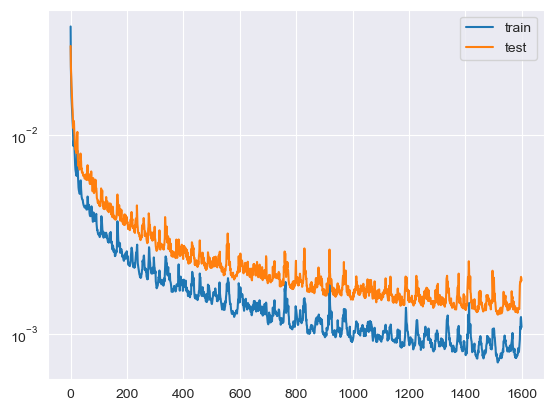

In [35]:
# plot losses
plt.plot(train_losses_60_4_layers_2005, label='train')
plt.plot(test_losses_60_4_layers_2005, label='test')
plt.legend()
# plot in log scale
plt.yscale('log')
plt.show()

In [36]:
# extract encoder from autoencoder
encoder_256_4_layers_2005 = model_256_4_layers_2005.encoder
# save encoder
torch.save(encoder_256_4_layers_2005, 'encoder_256_4_layers_2005.pt')
# load encoder
encoder_256_4_layers_2005 = torch.load('encoder_256_4_layers_2005.pt')

In [38]:
# create train and test data which are not scaled
sp500_train_2005, sp500_test_2005 = create_data(scale_to_std=False, scale_min_max=False)

C:\Users\Maciej\anaconda3\envs\pytorch_gpu\lib\site-packages\finta\finta.py:399: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for x, y in zip(x.fillna(0).iteritems(), y.iteritems()):
C:\Users\Maciej\anaconda3\envs\pytorch_gpu\lib\site-packages\finta\finta.py:399: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for x, y in zip(x.fillna(0).iteritems(), y.iteritems()):
C:\Users\Maciej\anaconda3\envs\pytorch_gpu\lib\site-packages\finta\finta.py:399: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for x, y in zip(x.fillna(0).iteritems(), y.iteritems()):
C:\Users\Maciej\anaconda3\envs\pytorch_gpu\lib\site-packages\finta\finta.py:399: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for x, y in zip(x.fillna(0).iteritems(), y.iteritems()):
C:\Users\Maciej\anaconda3\envs\pytorch_g

In [40]:
# drop SQZMI columns from dataframes
sp500_train_2005.drop(columns=['SQZMI'], inplace=True)
sp500_test_2005.drop(columns=['SQZMI'], inplace=True)

In [43]:
# create environment with 2005 data and encoder
env_weighted_256_2005 = SP500TradingEnvAutoencoder(sp500_weighted_train_2005, sp500_train_2005, window_len=60, encoder=encoder_256_4_layers_2005)

C:\Users\Maciej\anaconda3\envs\pytorch_gpu\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [44]:
# train model on 2005 data
model_2005 = PPO('MlpPolicy', env_weighted_256_2005, verbose=1)
model_2005.learn(total_timesteps=100_000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 633  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 3.56e+03    |
|    ep_rew_mean          | 0.607       |
| time/                   |             |
|    fps                  | 494         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.021264201 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.41       |
|    explained_variance   | 0.188       |
|    learning_rate        | 0.0003      |
|    loss              

In [45]:
# test model on train environment
obs = env_weighted_256_2005.reset()
for i in range(env_weighted_256_2005.end_tick):
    action, _states = model_2005.predict(obs, deterministic=True)
    obs, rewards, dones, info = env_weighted_256_2005.step(action)
    env_weighted_256_2005.render()
    if dones:
        print("info:", info)
        break

Episode tick: 1
Portfolio value: [0.99951124]
SP500: [0.7036235]
Cash: [0.29588777]
Done: False
Episode tick: 2
Portfolio value: [0.9954513]
SP500: [0.6208724]
Cash: [0.3745789]
Done: False
Episode tick: 3
Portfolio value: [0.99827766]
SP500: [0.99827766]
Cash: [0.]
Done: False
Episode tick: 4
Portfolio value: [1.0027508]
SP500: [1.0027508]
Cash: [0.]
Done: False
Episode tick: 5
Portfolio value: [1.0050254]
SP500: [1.0050254]
Cash: [0.]
Done: False
Episode tick: 6
Portfolio value: [1.005412]
SP500: [0.06514051]
Cash: [0.9402715]
Done: False
Episode tick: 7
Portfolio value: [1.0052502]
SP500: [0.01923021]
Cash: [0.98601997]
Done: False
Episode tick: 8
Portfolio value: [1.0052565]
SP500: [0.74899876]
Cash: [0.25625777]
Done: False
Episode tick: 9
Portfolio value: [1.0084698]
SP500: [0.5826646]
Cash: [0.42580515]
Done: False
Episode tick: 10
Portfolio value: [1.0038018]
SP500: [0.39221355]
Cash: [0.6115883]
Done: False
Episode tick: 11
Portfolio value: [0.99880505]
SP500: [0.49458858]
Cas

In [46]:
# test model on test environment
env_weighted_256_2005_test = SP500TradingEnvAutoencoder(sp500_weighted_test_2005, sp500_test_2005, window_len=60, encoder=encoder_256_4_layers_2005)
obs = env_weighted_256_2005_test.reset()
for i in range(env_weighted_256_2005_test.end_tick):
    action, _states = model_2005.predict(obs, deterministic=True)
    obs, rewards, dones, info = env_weighted_256_2005_test.step(action)
    env_weighted_256_2005_test.render()
    if dones:
        print("info:", info)
        break

C:\Users\Maciej\anaconda3\envs\pytorch_gpu\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Episode tick: 1
Portfolio value: [1.]
SP500: [0.]
Cash: [1.]
Done: False
Episode tick: 2
Portfolio value: [1.]
SP500: [0.]
Cash: [1.]
Done: False
Episode tick: 3
Portfolio value: [1.0013491]
SP500: [0.33245865]
Cash: [0.6688904]
Done: False
Episode tick: 4
Portfolio value: [1.0013491]
SP500: [0.]
Cash: [1.0013491]
Done: False
Episode tick: 5
Portfolio value: [1.0074544]
SP500: [0.6613464]
Cash: [0.34610796]
Done: False
Episode tick: 6
Portfolio value: [1.0074544]
SP500: [0.]
Cash: [1.0074544]
Done: False
Episode tick: 7
Portfolio value: [1.0074544]
SP500: [0.]
Cash: [1.0074544]
Done: False
Episode tick: 8
Portfolio value: [1.0074544]
SP500: [0.]
Cash: [1.0074544]
Done: False
Episode tick: 9
Portfolio value: [1.0074544]
SP500: [0.]
Cash: [1.0074544]
Done: False
Episode tick: 10
Portfolio value: [1.0074544]
SP500: [0.]
Cash: [1.0074544]
Done: False
Episode tick: 11
Portfolio value: [1.0074544]
SP500: [0.]
Cash: [1.0074544]
Done: False
Episode tick: 12
Portfolio value: [1.0074544]
SP500: 

In [47]:
# train model for more timesteps (200k)
model_200k_2005 = PPO('MlpPolicy', env_weighted_256_2005, verbose=1)
model_200k_2005.learn(total_timesteps=200_000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 609  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 3.56e+03    |
|    ep_rew_mean          | 0.704       |
| time/                   |             |
|    fps                  | 437         |
|    iterations           | 2           |
|    time_elapsed         | 9           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.020087812 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.42       |
|    explained_variance   | -2.93       |
|    learning_rate        | 0.0003      |
|    loss              

In [48]:
# test model on train environment
obs = env_weighted_256_2005.reset()
for i in range(env_weighted_256_2005.end_tick):
    action, _states = model_200k_2005.predict(obs)
    obs, rewards, dones, info = env_weighted_256_2005.step(action)
    env_weighted_256_2005.render()
    if dones:
        print("info:", info)
        break

Episode tick: 1
Portfolio value: [0.99930584]
SP500: [0.99930584]
Cash: [0.]
Done: False
Episode tick: 2
Portfolio value: [0.9970349]
SP500: [0.34728786]
Cash: [0.649747]
Done: False
Episode tick: 3
Portfolio value: [0.9979961]
SP500: [0.33947763]
Cash: [0.65851843]
Done: False
Episode tick: 4
Portfolio value: [1.002468]
SP500: [1.002468]
Cash: [0.]
Done: False
Episode tick: 5
Portfolio value: [1.004742]
SP500: [1.004742]
Cash: [0.]
Done: False
Episode tick: 6
Portfolio value: [1.0080768]
SP500: [0.5618326]
Cash: [0.44624418]
Done: False
Episode tick: 7
Portfolio value: [0.99966437]
SP500: [0.99966437]
Cash: [0.]
Done: False
Episode tick: 8
Portfolio value: [0.99967283]
SP500: [0.99967283]
Cash: [0.]
Done: False
Episode tick: 9
Portfolio value: [1.0014116]
SP500: [0.31528988]
Cash: [0.6861217]
Done: False
Episode tick: 10
Portfolio value: [0.9988579]
SP500: [0.21456076]
Cash: [0.78429717]
Done: False
Episode tick: 11
Portfolio value: [0.9985151]
SP500: [0.03393451]
Cash: [0.9645806]
Do

In [49]:
# test model on test environment
obs = env_weighted_256_2005_test.reset()
for i in range(env_weighted_256_2005_test.end_tick):
    action, _states = model_200k_2005.predict(obs)
    obs, rewards, dones, info = env_weighted_256_2005_test.step(action)
    env_weighted_256_2005_test.render()
    if dones:
        print("info:", info)
        break

Episode tick: 1
Portfolio value: [1.]
SP500: [0.]
Cash: [1.]
Done: False
Episode tick: 2
Portfolio value: [0.99723834]
SP500: [0.12293118]
Cash: [0.87430716]
Done: False
Episode tick: 3
Portfolio value: [0.99723834]
SP500: [0.]
Cash: [0.99723834]
Done: False
Episode tick: 4
Portfolio value: [0.9957736]
SP500: [0.17524749]
Cash: [0.8205261]
Done: False
Episode tick: 5
Portfolio value: [0.9957736]
SP500: [0.]
Cash: [0.9957736]
Done: False
Episode tick: 6
Portfolio value: [0.9957736]
SP500: [0.]
Cash: [0.9957736]
Done: False
Episode tick: 7
Portfolio value: [0.9957736]
SP500: [0.]
Cash: [0.9957736]
Done: False
Episode tick: 8
Portfolio value: [0.9954213]
SP500: [0.37378153]
Cash: [0.6216397]
Done: False
Episode tick: 9
Portfolio value: [0.9954213]
SP500: [0.]
Cash: [0.9954213]
Done: False
Episode tick: 10
Portfolio value: [0.9954213]
SP500: [0.]
Cash: [0.9954213]
Done: False
Episode tick: 11
Portfolio value: [0.9953746]
SP500: [0.08583243]
Cash: [0.9095422]
Done: False
Episode tick: 12
Po

In [50]:
# train model for less timesteps (50k)
model_50k_2005 = PPO('MlpPolicy', env_weighted_256_2005, verbose=1)
model_50k_2005.learn(total_timesteps=50_000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 529  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 3.56e+03   |
|    ep_rew_mean          | -0.31      |
| time/                   |            |
|    fps                  | 433        |
|    iterations           | 2          |
|    time_elapsed         | 9          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.02061697 |
|    clip_fraction        | 0.11       |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.41      |
|    explained_variance   | -0.967     |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0697    

In [51]:
# test model on train environment
obs = env_weighted_256_2005.reset()
for i in range(env_weighted_256_2005.end_tick):
    action, _states = model_50k_2005.predict(obs)
    obs, rewards, dones, info = env_weighted_256_2005.step(action)
    env_weighted_256_2005.render()
    if dones:
        print("info:", info)
        break

Episode tick: 1
Portfolio value: [1.]
SP500: [0.]
Cash: [1.]
Done: False
Episode tick: 2
Portfolio value: [1.]
SP500: [0.]
Cash: [1.]
Done: False
Episode tick: 3
Portfolio value: [1.0003035]
SP500: [0.10720332]
Cash: [0.8931002]
Done: False
Episode tick: 4
Portfolio value: [1.0040746]
SP500: [0.8453874]
Cash: [0.15868723]
Done: False
Episode tick: 5
Portfolio value: [1.0040746]
SP500: [0.]
Cash: [1.0040746]
Done: False
Episode tick: 6
Portfolio value: [1.0040746]
SP500: [0.]
Cash: [1.0040746]
Done: False
Episode tick: 7
Portfolio value: [1.0040746]
SP500: [0.]
Cash: [1.0040746]
Done: False
Episode tick: 8
Portfolio value: [1.0040823]
SP500: [0.9169145]
Cash: [0.0871678]
Done: False
Episode tick: 9
Portfolio value: [1.0084391]
SP500: [0.790013]
Cash: [0.21842599]
Done: False
Episode tick: 10
Portfolio value: [1.007391]
SP500: [0.0880603]
Cash: [0.9193307]
Done: False
Episode tick: 11
Portfolio value: [1.007391]
SP500: [0.]
Cash: [1.007391]
Done: False
Episode tick: 12
Portfolio value: [

In [52]:
# test model on test environment
obs = env_weighted_256_2005_test.reset()
for i in range(env_weighted_256_2005_test.end_tick):
    action, _states = model_50k_2005.predict(obs)
    obs, rewards, dones, info = env_weighted_256_2005_test.step(action)
    env_weighted_256_2005_test.render()
    if dones:
        print("info:", info)
        break

Episode tick: 1
Portfolio value: [0.9993675]
SP500: [0.2314074]
Cash: [0.7679601]
Done: False
Episode tick: 2
Portfolio value: [0.9774101]
SP500: [0.9774101]
Cash: [0.]
Done: False
Episode tick: 3
Portfolio value: [0.9803133]
SP500: [0.7154672]
Cash: [0.2648461]
Done: False
Episode tick: 4
Portfolio value: [0.97218794]
SP500: [0.97218794]
Cash: [0.]
Done: False
Episode tick: 5
Portfolio value: [0.9812463]
SP500: [0.9812463]
Cash: [0.]
Done: False
Episode tick: 6
Portfolio value: [0.9860373]
SP500: [0.9860373]
Cash: [0.]
Done: False
Episode tick: 7
Portfolio value: [0.9824686]
SP500: [0.9824686]
Cash: [0.]
Done: False
Episode tick: 8
Portfolio value: [0.9824686]
SP500: [0.]
Cash: [0.9824686]
Done: False
Episode tick: 9
Portfolio value: [0.9868727]
SP500: [0.9868727]
Cash: [0.]
Done: False
Episode tick: 10
Portfolio value: [0.99163914]
SP500: [0.92111254]
Cash: [0.0705266]
Done: False
Episode tick: 11
Portfolio value: [0.99163914]
SP500: [0.]
Cash: [0.99163914]
Done: False
Episode tick: 